In [1]:
%pip install graphviz
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
print(xs)
print(ys)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


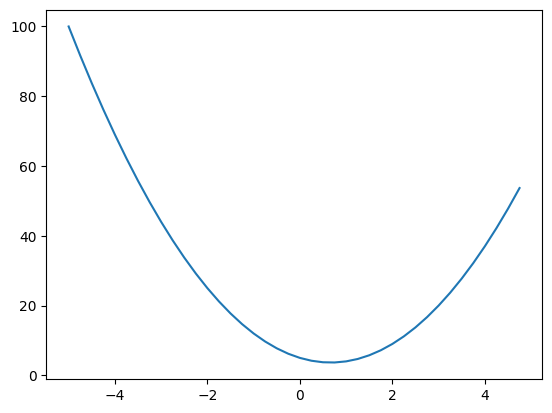

In [5]:
plt.plot(xs, ys)

# Here is the flow of building Micrograd
## Building datastructures for storing data
- Define a class that supports mathematical operations.
- It should hold the data of what values created a value (hold the childrens.
- It should also hold what operation created the value.
- Add support for visuatisation. (graphviz)
- Also store labels for every node, so that it contains the label and the value.
- it should support forward pass on it and visualise it.
- then calculate the derivative of the ouput node with respect to every node that eventually created it.
- The diagram should also show the gradients.
- Backpropogate and calculate derivatives of L with respect to every other node.

## Then Backpropogate through Neurons.
 

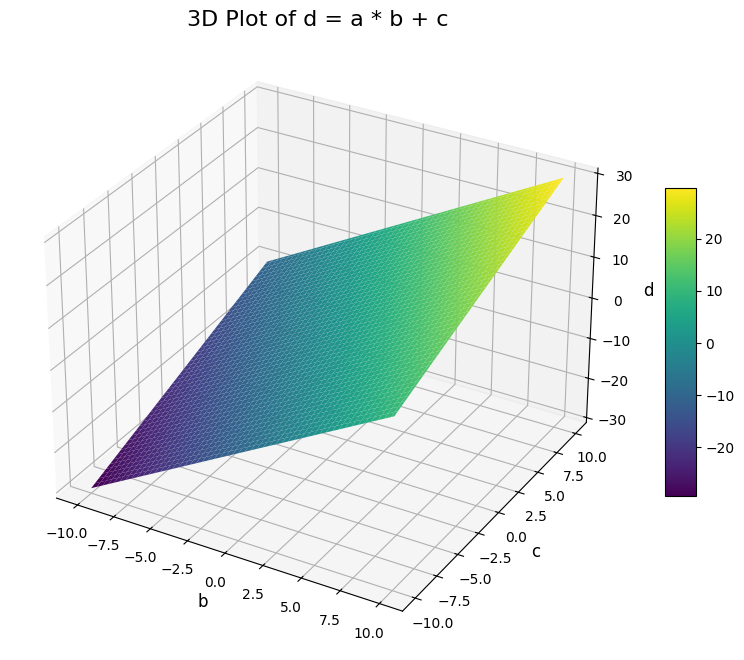

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Define fixed parameter
a = 2  # Fixed value for 'a'

# Define ranges for 'b' and 'c'
b = np.linspace(-10, 10, 100)
c = np.linspace(-10, 10, 100)

# Create a meshgrid for 'b' and 'c'
B, C = np.meshgrid(b, c)

# Calculate 'd' based on the function
D = a * B + C

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(B, C, D, cmap='viridis', edgecolor='none')

# Add labels and title
ax.set_title("3D Plot of d = a * b + c", fontsize=16)
ax.set_xlabel("b", fontsize=12)
ax.set_ylabel("c", fontsize=12)
ax.set_zlabel("d", fontsize=12)

# Add color bar to show the scale of 'd'
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()

In [142]:
# Implementing the Value Class
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.grad = 0.0
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"[Value: {self.data}]"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        def backward ():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        def backward ():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        def backward ():
            self.grad = out.grad * (1-t**2)
        out._backward = backward
        return out

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e + c
d.label="d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"
# (a*b+c)._prev

In [71]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

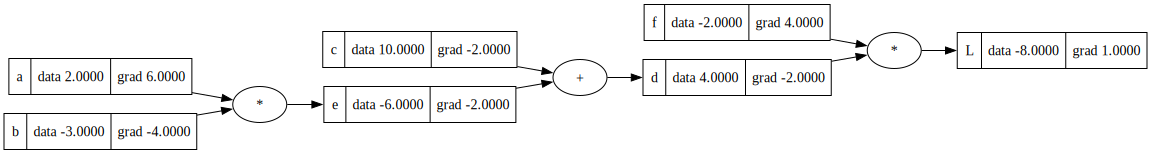

In [72]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = d.grad * 1.0
c.grad = d.grad * 1.0
a.grad = -3 * e.grad
b.grad = 2 * e.grad
draw_dot(L)

## Why are we doing this?

- The final variable d, is the output, which in our case will be the loss function.
- We want to minimise the loss function, which is the different between the expected output and the actual output.
- The output depends upon the leaf nodes, specifically a, b and c.
- We will calculate the derivative of the output for each and every leaf node, and tweak it to see how do we reach the minumum value of output.
- These leaf objects are weights in the neural network, a and b are input, which we don't change because the input is already fixed.

In [35]:
def lol():
    h = 0.001
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c
    d.label="d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c
    d.label="d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L2 = L.data + h

    print((L2 - L1)/h)
lol()

1.000000000000334


In [153]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88, label="b")

x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

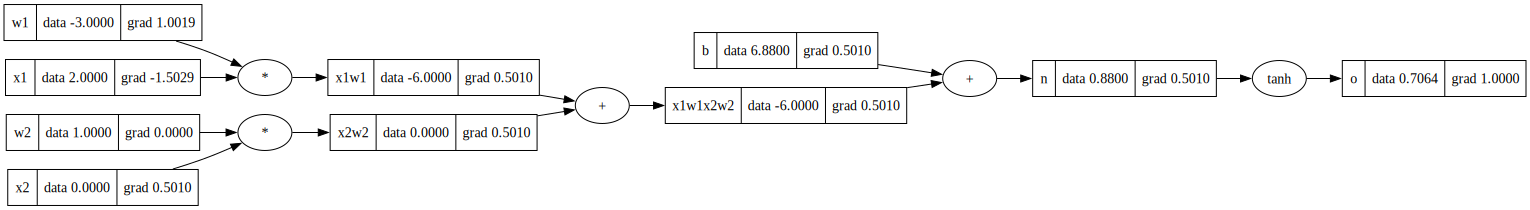

In [156]:
draw_dot(o)

In [155]:
o.grad = 1.0

topo = []
visited = set()
def topo_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topo_sort(child)
        topo.append(v)
topo_sort(o)

for node in reversed(topo):
    node._backward()

In [166]:
import random
class Neuron:
    def __init__(self, number_of_inputs):
        self.w = [Value (random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum(wi*xi for xi, wi in zip(self.w, x)) + self.b
        return act.tanh()


x=[2.0, 3.0]
n = Neuron(2)
n(x)

TypeError: unsupported operand type(s) for *: 'float' and 'Value'